In [1]:
import numpy as np
import pandas as pd
import math as math
from matplotlib import pyplot as plt
from sklearn import model_selection, preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse

import seaborn as sns

%matplotlib inline

## Исследование данных

#### Загрузка датасетов:

In [2]:
DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

train_data=pd.read_csv(DATASET_PATH)
test_data=pd.read_csv(TEST_DATASET_PATH)

Посмотрим на структуру тренировочного датасета:

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


Видим, что данные составляют 10000 записей, включают в себя типы int64, float64 и object. Часть признаков присутствует не полностью, в частности, LifeSquare (жилая площадь) и HealtCare_1 (показатель охраны здоровья)

Статистика тренировочного датасета:

In [4]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


Видим, что даные явно некорректны, и содержат аномальные значения. В частности, есть дома с нулевым количеством комнат, год представлен в неудобоваримом формате, в KitchenSquare попал год постройки дома и т.д.

Посмотрим на структуру тестового датасета:

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


Видим, что данные составляют 5000 записей, типы данных идентичны типам из тренировочного датасета. LifeSquare и HealthCare также присутствуют не полностью.

Статистика тестового датасета:

In [6]:
test_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,3959.0,36.158810,17.825287,0.333490,23.092026,32.925087,45.174091,303.071094
KitchenSquare,5000.0,5.976800,9.950018,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867


Ситуация аналогична тренировочному датасету.

Отобразим распределение целевой переменной 'Price':

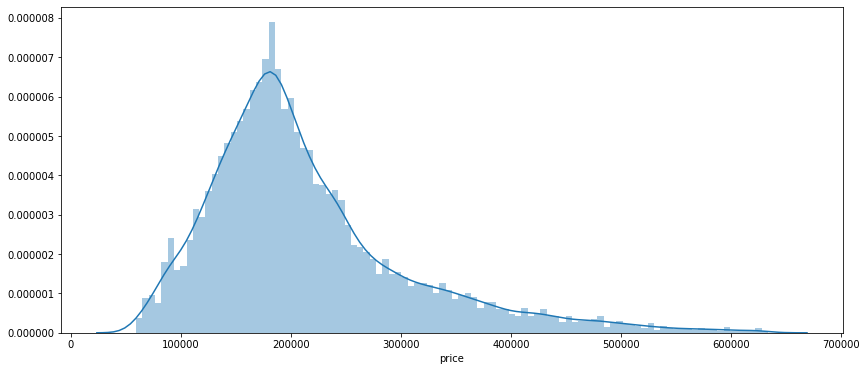

In [7]:
plt.figure(figsize = (14, 6))
sns.distplot(train_data['Price'], bins=100, kde=True)
plt.xlabel('price')
plt.show()

Визуально распределение цены имеет признак логнормального распределения.


Для дальнейшей работы необходимо преобразовать данные.


### Преобразование данных:

#### Преобразование данных будем выполнять по следующему алгоритму:
#### 1. Изменение типа данных и оцифровка категориальных признаков
#### 2. Заполнение пропущенных значений реалистичными данными
#### 3. Обработка выбросов и аномальных значений

##### 1. Изменение типа данных и оцифровка категориальных признаков:

Посмотрим, что за данные хранятся в object-столбцах:

In [8]:
object_data = train_data.select_dtypes(include='object')
object_data_columns = object_data.columns
object_data_columns

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

In [9]:
train_data['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [10]:
train_data['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [11]:
train_data['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Во всех столбцах типа 'object' находятся значения, соответствующие какой-то категории. Можно заменить их на числовые.

Определим функцию замены:

In [12]:
def change_category_to_number(data):
    '''Функция получает в качестве параметра датафрейм,
        определяет в нем признаки с типом "object",
        применяя OrdinalEncoder, переводит категориальные признаки в числовые с типом "int64",
        устанавливает значения этих признаков в исходный датафрейм и возвращает его'''
    
    #получим данные из столбцов типа 'object'
    object_data = data.select_dtypes(include='object')
    object_data_columns = object_data.columns
    
    #преобразуем категориальные признаки в числовые
    encoder = preprocessing.OrdinalEncoder(dtype='int64')
    encoder.fit(object_data)
    object_data = encoder.transform(object_data)
    
    #полученные значения запишем в исходный датафрейм
    data[object_data_columns] = object_data
    return data

In [13]:
train_data = change_category_to_number(train_data)

##### 2. Заполнение пропущенных данных реалистичными значениями:

Определим функцию, которая заменит NaN на медианные значения:

In [14]:
def replace_NaN_with_number(data):  
    NaN_columns=data.columns[data.isna().any()].tolist()
    for column_name in NaN_columns:
        count_NaN_values = data[column_name].isnull().sum()
        count_values = data.shape[0]
        data[column_name] = data[column_name].fillna(data[column_name].median())
    return data

In [15]:
#посмотрим, какие колонки содержат пропуски значений:
NaN_columns=train_data.columns[train_data.isna().any()].tolist()
NaN_columns

['LifeSquare', 'Healthcare_1']

Колонка LifeSquare - жилая площадь, и обычно должна занимать какую-то долю от реальной площади квартиры.
Вычислим эту долю, основываясь на заполненных значениях LifeSquare и соответствующих значения Square.
Дозаполним пропущенные значения LifeSquare в соответствии с долей жилой площади:

Определим фукнкцию вычисления значений одного поля в зависимости от доли другого поля

In [16]:
def set_share_values(data, set_ColumnName, get_ColumName):
    share = (data.loc[data[set_ColumnName].notnull(), set_ColumnName]/data.loc[data[set_ColumnName].notnull(), get_ColumName]).median()
    data[set_ColumnName] = data[set_ColumnName].fillna(data[get_ColumName] * share)
    return data

In [17]:
train_data = set_share_values(train_data,'LifeSquare','Square')

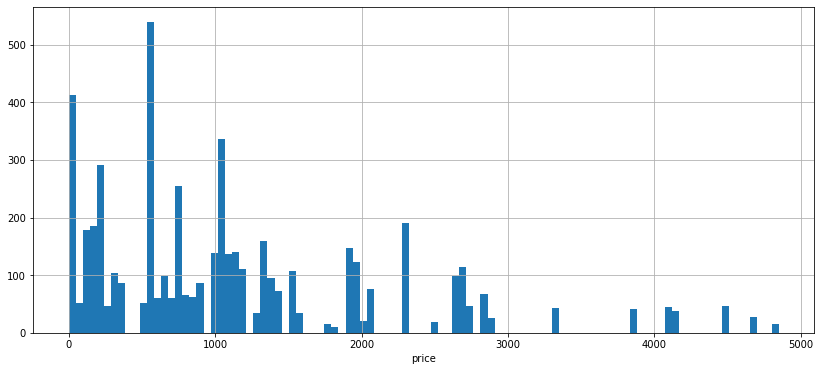

In [18]:
#ещё один признак Healthcare_1 содержит пропущенные значения
#посмотрим его распределение
plt.figure(figsize = (14, 6))
train_data['Healthcare_1'].hist(bins=100)
plt.xlabel('price')
plt.show()

In [19]:
#видим, что распределение данного признака не имеет под собой каких-либо оснований
#Заменим пропуски значений средним значением
#плюс попутно, если есть ещё какие-нибудь NaN значения - их тоже заменим на среднее:
train_data = replace_NaN_with_number(train_data)

##### 3. Обработка выбросов и аномальных значений:

Планомерно пройдём по каждому признаку:

In [20]:
train_data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Видим, что есть 8 квартир, у которых количество комнат = 0.
Заменим его на 1

Определим функцию, которая заменит нулевые значения в необходимых полях:

In [21]:
def set_value_from_zeros_to_values(data,set_ColumnName,setValue):
    data.loc[data[set_ColumnName] == 0, set_ColumnName] = setValue
    return data

In [22]:
train_data = set_value_from_zeros_to_values(train_data, 'Rooms',1)
train_data['Rooms'].value_counts()

2.0     3880
1.0     3713
3.0     2235
4.0      150
5.0       18
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [23]:
train_data.sort_values(['Square'], ascending=False)[['Square','LifeSquare','KitchenSquare','Price']].head(10)

,Square,LifeSquare,KitchenSquare,Price
6977,641.065193,638.163193,10.0,133529.681562
4262,604.705972,373.422265,1.0,187717.242538
4690,409.425181,410.639749,10.0,90470.430830
1982,275.645284,233.949309,26.0,455264.882666
1981,212.932361,211.231125,0.0,302211.260887
9910,200.334539,201.627361,25.0,528560.506016
8511,198.930182,123.139863,10.0,345665.209100
652,190.857689,107.376164,19.0,338644.075979
7201,186.692602,87.487080,32.0,423443.464367
5087,185.906396,84.830074,31.0,340273.238253


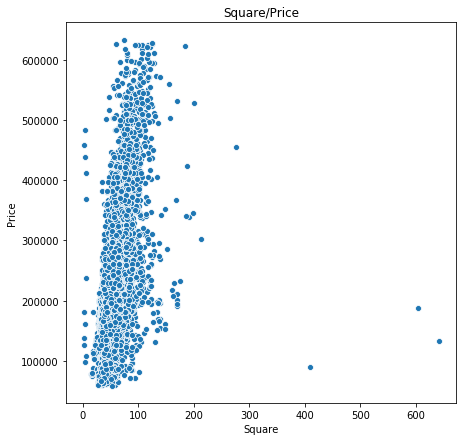

In [24]:
plt.figure(figsize=(7, 7))
           
sns.scatterplot(x=train_data['Square'], y=train_data['Price'])
    
plt.xlabel('Square')
plt.ylabel('Price')
plt.title('Square/Price')
plt.show()

Видим на графике, что наибольшие 3 точки по площади на графике явно относятся к выбросам. Это точки, с площадью больше 400 м2
Удалим из выборки эти значения.
Определим функцию, которая удаляет строки с значением поля больше определенного значения:

In [25]:
def delete_gross_values_rows(data,set_Column_name,max_value):
    indexNames = data[data[set_Column_name] > max_value ].index
    data.drop(indexNames , inplace=True)
    return data

In [26]:
#train_data = delete_gross_values_rows(train_data,'Square',400)

Опишем функцию, которая заменяет значения, превышающие определенный порог, на медианные значения:

In [27]:
def set_value_to_value(data,set_ColumnName,Value):
    data.loc[data[set_ColumnName] > Value, set_ColumnName] = 0
    return data

In [28]:
train_data = set_value_to_value(train_data,'Square', 400)

In [29]:
#Посмотрим выборку, отсортированную по KitchenSquare
train_data.sort_values(['KitchenSquare'], ascending=False).head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,1,1,2,629,1,900.0,0,0,0,108337.484207
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,105539.556275
9895,2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,1,1,2,469,0,900.0,0,0,1,234194.837047
2969,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015,0.072158,1,1,2,629,1,900.0,0,0,0,315245.521059
4651,12552,58,3.0,116.405693,113.109653,112.0,3,3.0,2016,0.437885,1,1,23,5735,3,1084.0,0,5,1,296165.936689


Видим, что в KitchenSquare почему-то попал год постройки дома
обнулим его.
Определим функцию, обнуляющую значения, превышающие определенный порог:

In [30]:
def set_value_from_values_to_zeros(data,set_ColumnName,value):
    data[ data[set_ColumnName] > value] = 0
    return data

In [31]:
train_data = set_value_from_values_to_zeros(train_data,'KitchenSquare', 123)

Добавим переменные, характеризующие другие величины:

In [32]:
def get_counter(data, get_Column_name,counter_name):
    counter_name = data[get_Column_name].value_counts().reset_index().rename(columns={'index':get_Column_name, get_Column_name:counter_name})
    data = data.merge(counter_name, on=get_Column_name, how='left') 
    return data  

In [33]:
train_data = get_counter(train_data,'DistrictId','number_of_apartmens')
train_data = get_counter(train_data,'Rooms','number_of_rooms')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,number_of_apartmens,number_of_rooms
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,33,7976,5,900.0,0,11,1,184966.930730,22,3880
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,46,10309,1,240.0,1,16,1,300009.450063,87,2235
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,34,7759,0,229.0,1,3,1,220925.908524,174,3880
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,23,5735,3,1084.0,0,5,1,175616.227217,179,3880
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,35,5776,1,2078.0,2,4,1,150226.531644,97,3711


### Обучение и оценка модели:

In [34]:
def show_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    print("Train MSE:\t" + str(round(mse(train_true_values, train_pred_values), 3)))
    print("Test MSE:\t" + str(round(mse(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12, 8))
    sns.distplot( train_true_values, kde = True, bins = 50, color='blue', hist_kws=dict(alpha=0.3, label='Train'), label='Train')
    sns.distplot( test_pred_values, kde = True, bins = 50, color='red',hist_kws=dict(alpha=0.3,label='Predict'), label='Predict')

    plt.show()

RF model
Train R2:	0.86
Test R2:	0.699
Train MSE:	1209617016.992
Test MSE:	2610504730.35


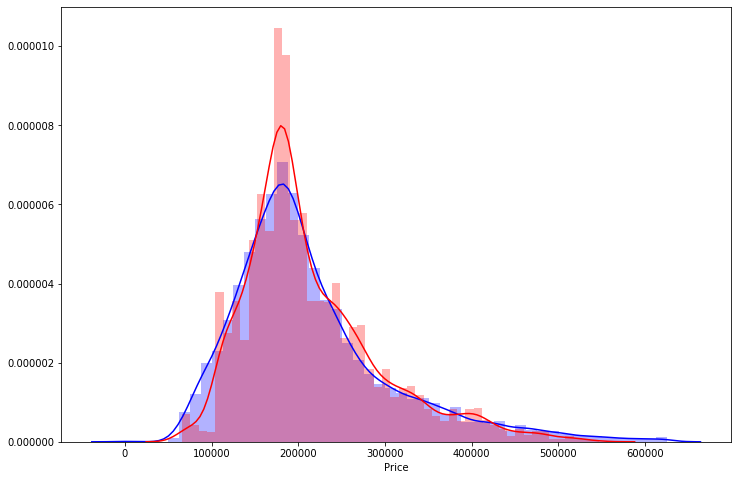

In [35]:
y = train_data['Price']
X = train_data.drop(['Price'], axis=1)
feature_names = X.columns

#дробим выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)
X_train = X_train.drop('Id', axis=1)
X_test = X_test.drop('Id', axis=1)
    
#нормализуем данные
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.fit_transform(X_test)

# Эмпирическим путем выявлено, что наилучший результат дает модель RandomForestRegressor
# с параметрами (random_state=42, max_depth=10, n_estimators=10)

rf_model = RandomForestRegressor(random_state=42, max_depth=10, n_estimators=10)
rf_model.fit(X_train, y_train)

#test['Price'] = model.predict(test.drop('Id', axis=1))
train_predictions = rf_model.predict(X_train)
test_predictions = rf_model.predict(X_test)

#train_predictions = rf_model.predict(X_train)
#test_predictions = rf_model.predict(X_test)

#scores = cross_val_score(rf_model, X_train,y_train, cv=10, scoring='r2')
#train_predictions = cross_val_predict(rf_model, X_train, y_train, cv=10)
#test_predictions = cross_val_predict(rf_model, X_test, y_test, cv=10)
    
print('RF model')
show_preds(y_train, train_predictions, y_test, test_predictions)

### Подготовка тестовых данных:

In [36]:
def data_preparation(test_data):
    test_data = change_category_to_number(test_data)
    test_data = set_share_values(test_data,'LifeSquare','Square')
    test_data = replace_NaN_with_number(test_data)
    test_data = set_value_from_zeros_to_values(test_data, 'Rooms',1)
    test_data = delete_gross_values_rows(test_data,'Square',400)
    test_data = set_value_from_values_to_zeros(test_data,'KitchenSquare', 123)
    test_data = get_counter(test_data,'DistrictId','number_of_apartmens')
    test_data = get_counter(test_data,'Rooms','number_of_rooms')
    return test_data

In [37]:
test_data = data_preparation(test_data)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
Id                     5000 non-null int64
DistrictId             5000 non-null int64
Rooms                  5000 non-null float64
Square                 5000 non-null float64
LifeSquare             5000 non-null float64
KitchenSquare          5000 non-null float64
Floor                  5000 non-null int64
HouseFloor             5000 non-null float64
HouseYear              5000 non-null int64
Ecology_1              5000 non-null float64
Ecology_2              5000 non-null int64
Ecology_3              5000 non-null int64
Social_1               5000 non-null int64
Social_2               5000 non-null int64
Social_3               5000 non-null int64
Healthcare_1           5000 non-null float64
Helthcare_2            5000 non-null int64
Shops_1                5000 non-null int64
Shops_2                5000 non-null int64
number_of_apartmens    5000 non-null int64
number_of_rooms    

In [38]:
Predict = test_data.drop('Id', axis=1)
test_data['Price'] = rf_model.predict(Predict)
test_data.loc[:, ['Id','Price']].to_csv('VPodoynitsyn_predictions.csv', index=None)

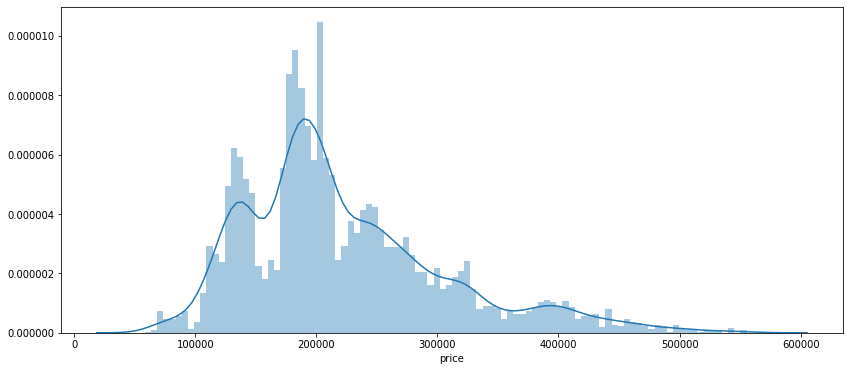

In [39]:
plt.figure(figsize = (14, 6))
sns.distplot(test_data['Price'], bins=100, kde=True)
plt.xlabel('price')
plt.show()
